<a href="https://colab.research.google.com/github/MarsDana/fakenewsdetectionproject/blob/main/BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers[torch]
!pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.6/336.6 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.2.1
    Uninstalling accelerate-1.2.1:
      Successfully uninstalled accelerate-1.2.1


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import AutoTokenizer
from tqdm import tqdm

# Load and preprocess datasets
def load_datasets():
    # Load ISOT datasets
    fake_isot = pd.read_csv("/content/drive/MyDrive/datasets/ISOT/Fake.csv")
    real_isot = pd.read_csv("/content/drive/MyDrive/datasets/ISOT/True.csv")
    real_isot['label'], fake_isot['label'] = 1, 0

    # Load PolitiFact datasets
    fake_politifact = pd.read_csv("/content/drive/MyDrive/datasets/fakenewsnet/politifact_fake.csv")
    real_politifact = pd.read_csv("/content/drive/MyDrive/datasets/fakenewsnet/politifact_real.csv")
    fake_politifact['label'], real_politifact['label'] = 0, 1
    fake_politifact.rename(columns={'title': 'text'}, inplace=True)
    real_politifact.rename(columns={'title': 'text'}, inplace=True)

    # Load LIAR dataset
    liar = pd.read_csv("/content/drive/MyDrive/datasets/liar_dataset/test.tsv", sep="\t", header=None)
    liar.columns = [
        "id", "label", "statement", "subject", "speaker", "job", "state", "party",
        "barely_true_counts", "false_counts", "half_true_counts", "mostly_true_counts", "pants_on_fire_counts", "context"
    ]
    liar['label'] = liar['label'].apply(lambda x: 1 if x in ["true", "mostly-true", "half-true"] else 0)
    liar = liar[["statement", "label"]].rename(columns={"statement": "text"})

    # Combine datasets
    combined_df = pd.concat([real_isot, fake_isot, real_politifact, fake_politifact, liar], ignore_index=True)
    return combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Prepare datasets for training
def prepare_datasets(df, test_size=0.2, reduce_frac=1/3):
    train_df, val_df = train_test_split(df, test_size=test_size, random_state=42)
    train_df = train_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=reduce_frac, random_state=42))
    val_df = val_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=reduce_frac, random_state=42))
    return train_df, val_df

# Dataset class for BiLSTM
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

# BiLSTM Model Definition
class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, pad_idx):
        super(BiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 for bidirectional LSTM

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        lstm_out, _ = self.lstm(embedded)
        pooled = lstm_out.mean(dim=1)  # Global average pooling
        output = self.fc(pooled)
        return output

# Load datasets and tokenizer
df = load_datasets()
train_df, val_df = prepare_datasets(df)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Dataset and DataLoader
max_length = 128
train_dataset = TextClassificationDataset(
    texts=train_df["text"].tolist(),
    labels=train_df["label"].tolist(),
    tokenizer=tokenizer,
    max_length=max_length
)
val_dataset = TextClassificationDataset(
    texts=val_df["text"].tolist(),
    labels=val_df["label"].tolist(),
    tokenizer=tokenizer,
    max_length=max_length
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model, Optimizer, and Loss Function
vocab_size = tokenizer.vocab_size
pad_idx = tokenizer.pad_token_id
embed_dim = 128
hidden_dim = 256
num_classes = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTMClassifier(vocab_size, embed_dim, hidden_dim, num_classes, pad_idx).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Track metrics
train_losses = []
val_roc_aucs = []

# Training and Evaluation Functions
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader):
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate_model(model, dataloader, device):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            targets.extend(labels.cpu().numpy())
    return {
        "accuracy": accuracy_score(targets, preds),
        "precision": precision_score(targets, preds, average="weighted"),
        "recall": recall_score(targets, preds, average="weighted"),
        "f1": f1_score(targets, preds, average="weighted"),
    }


# Initialize tracking variables
training_losses = []
val_losses = []
roc_aucs = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

for epoch in range(5):
    # Train the model
    train_loss = train_model(model, train_loader, optimizer, criterion, device="cuda")
    training_losses.append(train_loss)

    # Evaluate on the validation set
    model.eval()
    val_loss = 0
    preds, targets, pred_probs = [], [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to("cuda")
            labels = batch["labels"].to("cuda")

            outputs = model(input_ids)
            val_loss += criterion(outputs, labels).item()
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())  # Predicted labels
            targets.extend(labels.cpu().numpy())
            pred_probs.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())  # Positive class probabilities

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Calculate metrics
    accuracy = accuracy_score(targets, preds)
    precision = precision_score(targets, preds, average="weighted")
    recall = recall_score(targets, preds, average="weighted")
    f1 = f1_score(targets, preds, average="weighted")
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

    # Calculate ROC-AUC
    roc_auc = roc_auc_score(targets, pred_probs)
    roc_aucs.append(roc_auc)

    # Print Final Results
    print("Final Results:")
    print(f"Train Loss: {training_losses[-1]:.4f}")
    print(f"Validation Loss: {val_losses[-1]:.4f}")
    print(f"Accuracy: {accuracies[-1]:.4f}")
    print(f"Precision: {precisions[-1]:.4f}")
    print(f"Recall: {recalls[-1]:.4f}")
    print(f"F1-Score: {f1_scores[-1]:.4f}")
    print(f"ROC-AUC: {roc_aucs[-1]:.4f}")


<ipython-input-12-3cf7b1ddd559>:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = train_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=reduce_frac, random_state=42))
<ipython-input-12-3cf7b1ddd559>:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  val_df = val_df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=reduce_frac, random_state=42))
100%|██████████| 3

Final Results:
Train Loss: 0.2384
Validation Loss: 0.0734
Accuracy: 0.9682
Precision: 0.9700
Recall: 0.9682
F1-Score: 0.9682
ROC-AUC: 0.9963


100%|██████████| 394/394 [00:40<00:00,  9.81it/s]


Final Results:
Train Loss: 0.0725
Validation Loss: 0.0616
Accuracy: 0.9692
Precision: 0.9708
Recall: 0.9692
F1-Score: 0.9691
ROC-AUC: 0.9973


100%|██████████| 394/394 [00:41<00:00,  9.56it/s]


Final Results:
Train Loss: 0.0666
Validation Loss: 0.0589
Accuracy: 0.9695
Precision: 0.9711
Recall: 0.9695
F1-Score: 0.9694
ROC-AUC: 0.9977


100%|██████████| 394/394 [00:40<00:00,  9.71it/s]


Final Results:
Train Loss: 0.0606
Validation Loss: 0.0538
Accuracy: 0.9701
Precision: 0.9716
Recall: 0.9701
F1-Score: 0.9701
ROC-AUC: 0.9979


100%|██████████| 394/394 [00:40<00:00,  9.69it/s]


Final Results:
Train Loss: 0.0557
Validation Loss: 0.0574
Accuracy: 0.9708
Precision: 0.9711
Recall: 0.9708
F1-Score: 0.9708
ROC-AUC: 0.9979


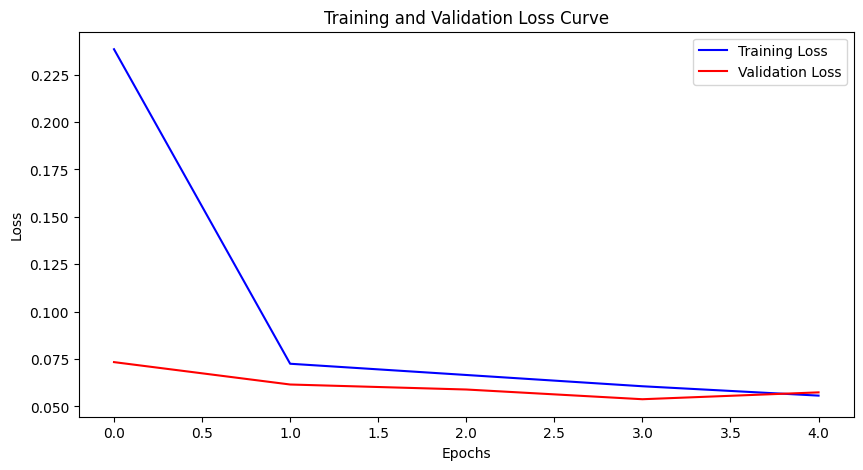

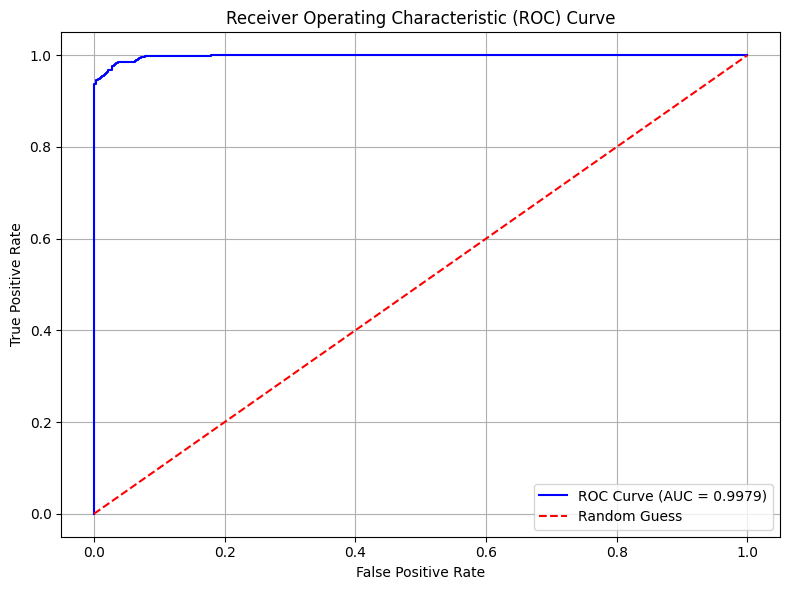

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plotting the Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss', color='b')
plt.plot(val_losses, label='Validation Loss', color='r')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()


# Plot ROC Curve for the Final Epoch
fpr, tpr, _ = roc_curve(targets, pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_aucs[-1]:.4f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
